# Provenance Grahp visualization

AiiDA allows us to visualize graphs of executed workflows

In [5]:
%load_ext aiida

In [6]:
%aiida

Loaded AiiDA DB environment - profile name: c2sm.

In [7]:
from aiida import common, orm, engine
from aiida.tools import visualization as aviz
import pathlib

## Customizing graph generation

We can custimize the graph generated by AiiDA with callback functions. Below we do this to shrink some otherwise unwieldy node representations (file contents) and to highlight a specific path of data flow from some input files to the final results.

In [8]:
def my_sublabels(node: orm.Node) -> str:
    """Trim down text in Str instances (which are written into namelist files and can be large in this case)."""
    if node.class_node_type == 'data.core.str.Str.':
        lines = node.value.splitlines()
        if len(lines) < 5:
            return node.value
        else:
            return "\n".join([*lines[:3], "...", lines[-1]])
    return aviz.default_node_sublabels(node)


def my_link_styles(link_pair: orm.LinkPair, add_label: bool, add_type: bool) -> dict:
    """Highlight certain graph edges."""
    style = aviz.default_link_styles(link_pair, add_label, add_type)
    if link_pair.link_type in [common.LinkType.INPUT_CALC, common.LinkType.CREATE] and link_pair.link_label in ["gcm_data", "gcm_prepared", "converted", "gcm_converted", "restart_file_dir", "restart_file_name"]:
        style["color"] = "red"
        style["penwidth"] = 4
    return style

## Growing a graph from a specific node

The functions below take the PK of a node and grow the graph either recursively (`full_graph`) or just by one connection in both directions of data flow (input & output).
The AiiDA Jupyter Lab extensions allow us to display the graph right here, but we can also write it to file.

In [9]:
def full_graph(node_nr: int, annotate_links: str, **kwargs) -> aviz.Graph:
    g = aviz.Graph(graph_attr={"size": "16,16"}, node_sublabel_fn=my_sublabels, link_style_fn=my_link_styles, **kwargs)
    g.recurse_ancestors(orm.load_node(node_nr), annotate_links=annotate_links)
    g.recurse_descendants(orm.load_node(node_nr), annotate_links=annotate_links)
    return g


def local_graph(node_nr: int, annotate_links: str, **kwargs) -> aviz.Graph:
    graph = aviz.Graph(graph_attr={"size": "16,16"}, node_sublabel_fn=my_sublabels, link_style_fn=my_link_styles, **kwargs)
    graph.add_incoming(load_node(node_nr), annotate_links=annotate_links)
    graph.add_outgoing(load_node(node_nr), annotate_links=annotate_links)
    return graph


def store_graph(graph: aviz.Graph, dir: pathlib.Path, base_name: str) -> None:
    graph.graphviz.render(dir / base_name)
    graph.graphviz.save(dir / (base_name + ".dot"))


GRAPHDIR = pathlib.Path("/Users/ricoh/Documents/aiida-c2sm")

## Graph examples

Let's start by looking at the (data-) dependencies inside a GCM2Icon workflow

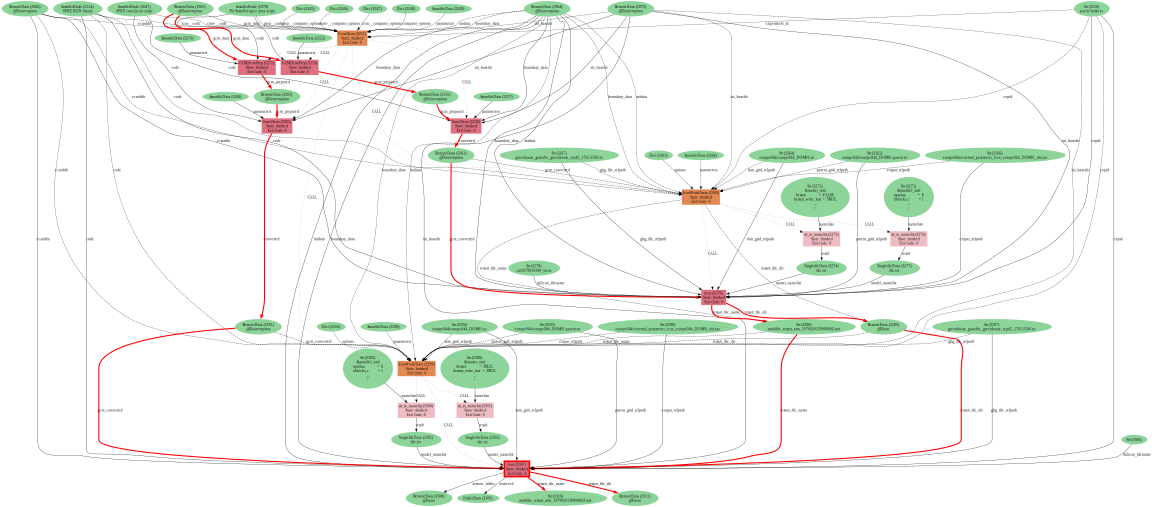

In [10]:
PK = 3307
spice_graph = full_graph(PK, annotate_links="label")
# store_graph(spice_graph, GRAPHDIR, "simple_spice_graph")
spice_graph.graphviz

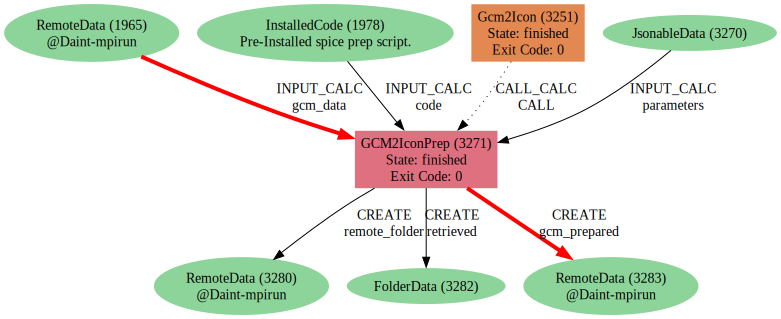

In [11]:
PK = 3271
prep_graph = local_graph(PK, annotate_links="both")
# store_graph(prep_graph, GRAPHDIR, "prep_graph")
prep_graph.graphviz

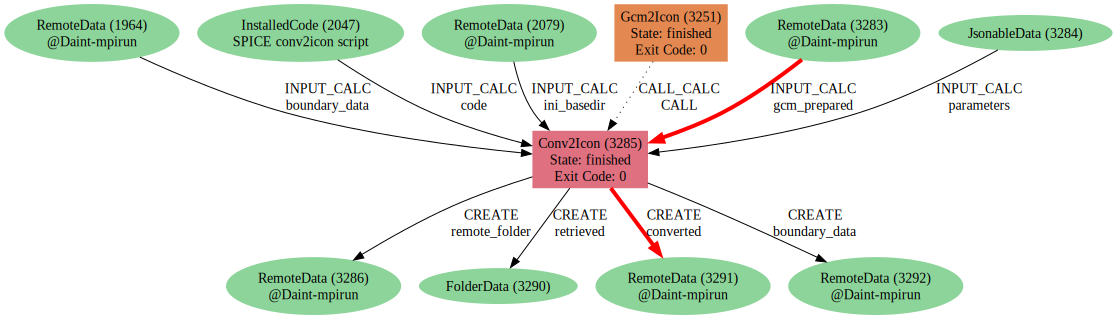

In [14]:
PK = 3285
conv_graph = local_graph(PK, annotate_links="both")
#store_graph(conv_graph, GRAPHDIR, "conv_graph")
conv_graph.graphviz

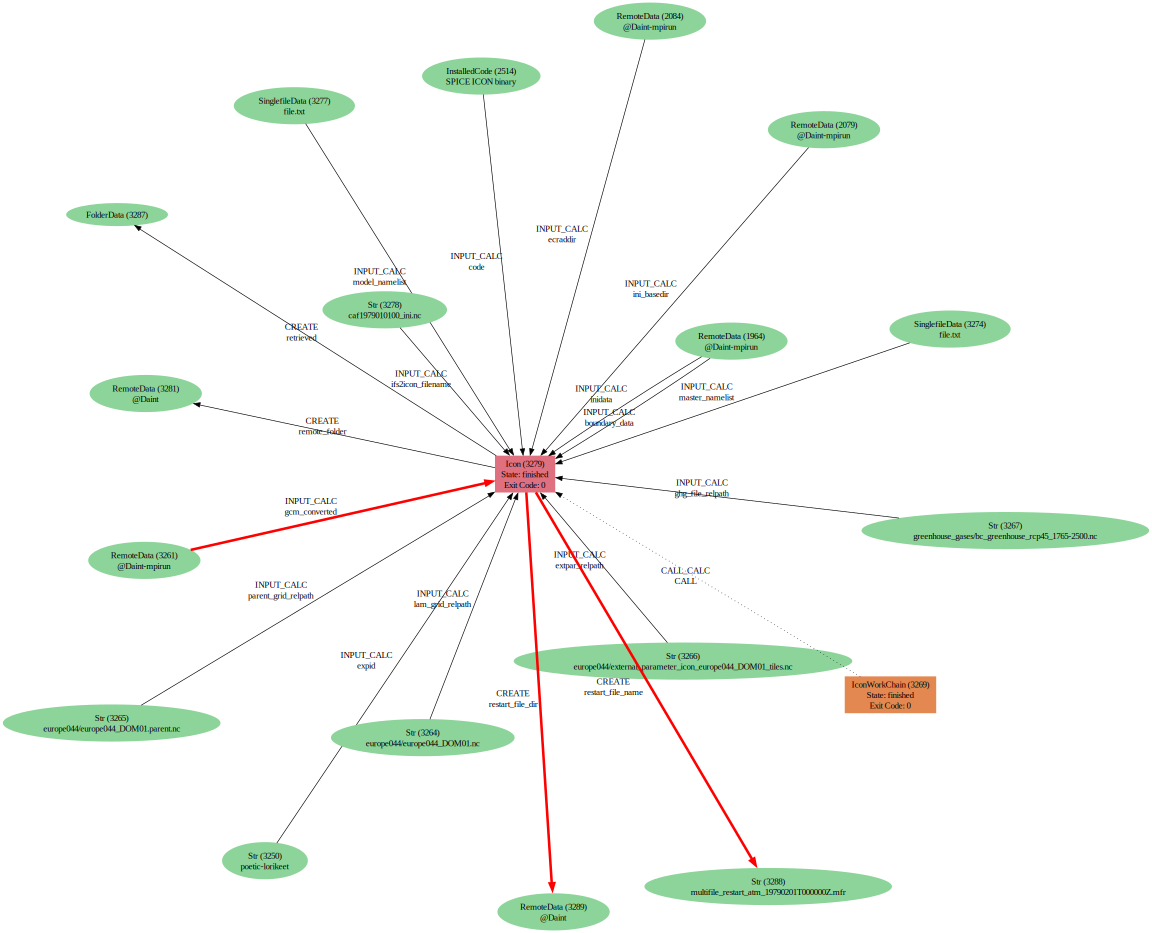

In [15]:
PK = 3279
icon_graph = local_graph(PK, annotate_links="both", engine="sfdp")
#store_graph(icon_graph, GRAPHDIR, "icon_graph")
icon_graph.graphviz